## Bayesian parameter estimation using Importance Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

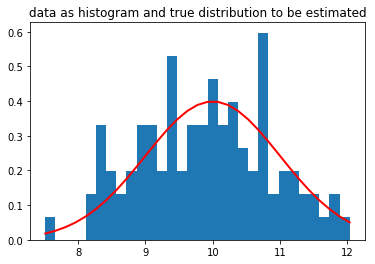

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal',
                        prior_name = ['uniform','lognormal'], prior_params = [[0, 15], [1, 0, 1]])

AttributeError: 'Distribution' object has no attribute 'n_params'

In [4]:
# Learn the unknown parameters using IS
bayes_estimator = BayesParameterEstimation(model=candidate_model, data=data, sampling_method = 'IS', nsamples=10000)

UQpy: Parameter estimation analysis completed!


1.0000000000000002


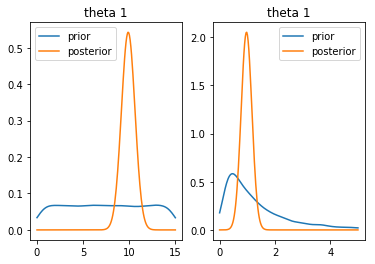

In [5]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='posterior')
ax[0].legend()
ax[0].set_title('theta 1')

domain = np.linspace(0, 5, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='posterior')
ax[1].legend()
ax[1].set_title('theta 1')

plt.show()

## Regression model

In [6]:
# Generate data from a quadratic equation, add some noise to it
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_1', 'theta_2'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[  0.53380636   0.7542323   -0.46150348   1.17160995   3.41649582
   2.70456121   3.36685363   4.88448673   9.16231112   7.38601343
  11.08518082  13.87784474  14.48791436  17.26899004  19.4363021
  21.08104618  25.13252786  27.18921604  31.22512251  33.96712459
  36.49448463  40.97716021  45.9100564   48.21470843  52.13904598
  57.16369186  61.91699578  65.39570166  69.14839018  76.23093135
  81.52033212  84.96420583  90.62860071  98.96873008 102.86402164
 109.25745894 115.86420636 120.81059999 129.62691971 134.23749686
 141.62524643 146.96537302 155.35863657 163.3166653  171.07735871
 176.18852717 186.37840805 192.37719947 201.50294343 209.36563105]


In [7]:
candidate_model = Model(n_params=2, model_type='python',
                        model_script='pfn_models.py', model_object_name = 'model_quadratic', 
                        error_covariance=error_covariance)

In [8]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method='IS', nsamples=200000,
                                           pdf_proposal=['normal','normal'], pdf_proposal_params=[[0, 2], [0, 2]])

(200000, 2)
UQpy: Parameter estimation analysis completed!
[0. 0. 0. ... 0. 0. 0.]


1.0000000000000004


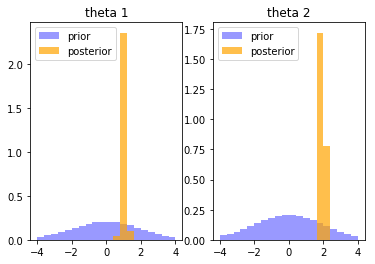

In [9]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(x=s[:,i], weights=None, density=True, range=(-4, 4), bins = 20, color='blue', alpha=0.4, label='prior')
    ax[i].hist(x=s[:,i], weights=w, density=True, range=(-4, 4), bins = 20, color='orange', alpha=0.7, label='posterior')
    ax[i].legend()
    ax[i].set_title('theta {}'.format(i+1))

plt.show()

Effective sample size is ne=14.22469984684042, for a total number of samples=200000
max_weight = 0.1745853989711723, min_weight = 0.0


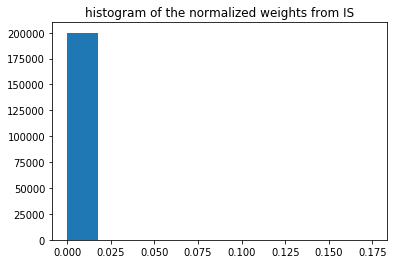

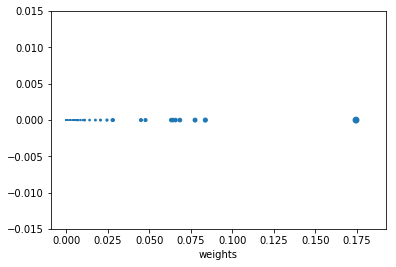

In [10]:
Diagnostics(sampling_method='IS', sampling_outputs = bayes_estimator)